# K Nearest Neighbors (KNN) classification

1. Binary classification with KNN from sklearn
2. Multi-class classifiction with KNN from sklearn
3. Multi-class classification with KNN from scratch

Sources:
* https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc
* https://www.analyticsvidhya.com/blog/2021/04/simple-understanding-and-implementation-of-knn-algorithm/
* https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/
https://towardsdatascience.com/how-to-build-knn-from-scratch-in-python-5e22b8920bd2

In [1]:
import sys, os, re, gzip, json, pickle, shutil, random, joblib, math

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False



## Load in dataset with mapped genres. 

In [2]:
# paths
metadata_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents/myspace_mp3s/metadata.json.gz'
genre_map_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents/myspace_mp3s/genre_map.pkl'
mfcc_path = 'C:/Users/tianyi/Northeastern University/Machine Learning Final Project - Music Classification - Documents/audio_features/mfcc'

In [3]:
# choose two binary genres to use for binary classifier
binary_genres = ['metal', 'classical']
lab_idx = {g:i for i,g in enumerate(binary_genres)}
lab_idx

{'metal': 0, 'classical': 1}

In [4]:
# genre counts (# samples per genre)
genre_cts = {}
for genre in os.listdir(mfcc_path):
    genre_path = '%s/%s' % (mfcc_path, genre)
    if genre == 'desktop.ini':
        continue
    genre_cts[genre] = len(os.listdir(genre_path))
    
# number samples for genre that has min samples in binary list (out of metal and classical)
min_recs = min([genre_cts[g] for g in binary_genres])    

# print counts for each genre
for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])

rock 13158
metal 8782
alternative 8778
rap 5906
dance 5624
pop 4684
jazz 4552
hip_hop 4526
experimental 3686
other 3544
world 2225
electronic 2127
folk 1804
punk 1729
blues 1472
ambient 1299
reggae 1114
goth 722
acoustic 678
country 533
house 512
classical 486
spiritual 369
oldies 248
progressive 221
funk 142
easy_listening 131
spoken_word 130
bluegrass 47
industrial 44
showtunes 38
disco 23


In [5]:
# get list of all 32 final genres
genres = list(genre_cts.keys())
print(genres)

['acoustic', 'alternative', 'ambient', 'bluegrass', 'blues', 'classical', 'country', 'dance', 'disco', 'easy_listening', 'electronic', 'experimental', 'folk', 'funk', 'goth', 'hip_hop', 'house', 'industrial', 'jazz', 'metal', 'oldies', 'other', 'pop', 'progressive', 'punk', 'rap', 'reggae', 'rock', 'showtunes', 'spiritual', 'spoken_word', 'world']


In [6]:
# loading in the metadata and genre map
# metadata not used in this model; has original genres before mapping
with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
    metadata = json.load(fz)

with open(genre_map_path, 'rb') as f:
    genre_map = pickle.load(f)
    
#example metadata
kys = list(metadata.keys())
ky=kys[0]
ky, metadata[ky]

('46/std_1f69563352d19cb0132334cd0d3adeaf.mp3',
 {'song_name': 'big_yellow_moon',
  'artist_name': 'bill_nelson',
  'mp3_zipname': '46',
  'mp3_filename': 'std_1f69563352d19cb0132334cd0d3adeaf.mp3',
  'genres': ['rock', 'electronica', 'alternative']})

In [7]:
# show min recs (the samples we will take from each of the binary classes to 
# avoid imbalanced data)
min_recs

486

## Feature Extraction

First look at the mfcc lengths across the data in the two classes we are working with. Then, extract mfccs and process them (so they are all the same shape) to use as features. 

In [8]:
def get_mfcc_lengths(mfcc_path, genres, max_recs):
    '''
        Gets the lengths of each mfcc file (one per song) across 
        each genre that we are working with. 
        
        mfcc_path: path to mfcc files (currently on OneDrive)
        genres: list of genres we are working with (coudl be binary or multi)
        max_recs: the genre that has the least number of samples
    '''
    
    widths=[] # holds the lens of each np array (for each song) --> columns
    heights = [] # rows
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre) # get path to all song mfccs in current genre
        ct = 0
        file_errors = 0
        for fn in os.listdir(genre_path): # for each song mfcc (only do as many songs as min genre so classes are even)
            fp = '%s/%s' % (genre_path, fn) # path to mfcc
            try:
                mfcc = np.load(fp) # load the np file
                widths.append(mfcc.shape[1]) # get the number of columns in the np array
                heights.append(mfcc.shape[0]) # get heights of the np array
                ct+=1
            except:
                file_errors += 1
            if ct>=max_recs:
                break
            
    # files that aren't loaded by onedrive won't read in (should be 0)
    print('Missed files: ', file_errors)
    l = np.array(widths)
    h = np.array(heights)
    
    return l, h

Missed files:  0
Mean mfcc widths: 9853.0833, std: 4784.7813
Mean mfcc height: 20.0000, std: 0.0000



Width Histogram for Metal and Classical Genres


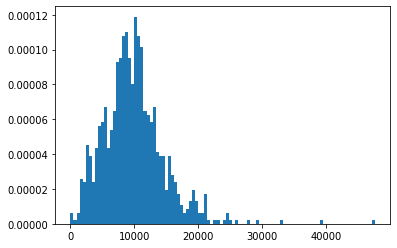

In [9]:
l, h = get_mfcc_lengths(mfcc_path, binary_genres, min_recs)

print('Mean mfcc widths: %.4f, std: %.4f' % (l.mean(), l.std())) #11098.8838, std: 4614.7522
print('Mean mfcc height: %.4f, std: %.4f' % (h.mean(), h.std())) #11098.8838, std: 4614.7522
print('\n\n')
print('Width Histogram for Metal and Classical Genres')
plt.hist(l, bins=100, density=True)
plt.show()

In [10]:
print('Max mfcc width: ', l.max())
print('Max mfcc height: ', h.max())

Max mfcc width:  47614
Max mfcc height:  20


In [11]:
def shuffle_data(x, y):
    '''
    Shuffles x and y data. 
    '''
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    
    return x, y


def normalize_data(x):
    '''
    Normalizes x data. 
    '''
    return (x-x.mean())/x.std()


def get_mfccs(mfcc_path, genres, lab_idx, max_recs):
    '''
    Open and process mfcc and return as x and y arrays.
    '''
    
    # save all x and y values
    mfccs = []
    y=[]
    i = 0
    
    # loop over each genre we are working with
    for genre in genres:
        
        # extract path to all song mfccs in current genre
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        # loop over each mfcc in current genre
        for fn in os.listdir(genre_path): 
            
            i += 1
            # get path to mfcc
            fp = '%s/%s' % (genre_path, fn)
            
            # load mfcc and transpose/take mean
            mfcc = np.load(fp) 
            mfcc = np.mean(mfcc.T,axis=0)
            mfccs.append(mfcc)
            
            # append target label to list
            y.append(lab_idx[genre])
            
            # for creating balanced dataset
            ct+=1
            if ct>=max_recs: 
                break
           
    # normalize data and create arrays
    x = np.array(mfccs)
    x = normalize_data(x)
    y = np.array(y)
    
    return shuffle_data(x, y)

In [12]:
# 972 samples, 20 features per sample for Metal and Classical
x, y = get_mfccs(mfcc_path, binary_genres, lab_idx, min_recs)
x.shape, y.shape

((972, 20), (972,))

In [13]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

training:  (777, 20) (777,)
testing:  (195, 20) (195,)


## KNN Model (sklearn library)

### Binary classification

This binary classifier will classify two genres selected at random: Metal (0) and Classical (1). 

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [16]:
# choose the best value of k
# The K value when test error stabilizes and is low is considered as optimal value for K

def choose_k_value():
    '''
    Displays error for each value of k between 1 and 15, plot can then be
    examined to select the best value of k. 
    '''

    train_errors = []
    test_errors = []

    # use values of k 1-15
    for k in range(1,15):

        # create and fit classifier
        knn= KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)

        # predict with x_train
        y_pred_train= knn.predict(x_train)
        train_errors.append(np.mean(y_train != y_pred_train))

        # predict with x_test
        y_pred_test = knn.predict(x_test)
        test_errors.append(np.mean(y_test!= y_pred_test))

    plt.plot(range(1,15), train_errors, label="Error from training data")
    plt.plot(range(1,15), test_errors, label="Error from testing data")
    plt.xlabel('k Value')
    plt.ylabel('Error')
    plt.legend()


Error for each k value for binary classification (Metal and Classical)


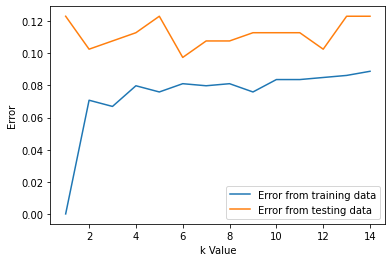

In [17]:
print('Error for each k value for binary classification (Metal and Classical)')
choose_k_value()

In [18]:
# It looks like k=3 has the lowest error (for test data), but it starts to level off around 10 or 11 (and then dips)
# down again around 14.
# I will choose 11 since this is where k seems most level. 

knn= KNeighborsClassifier(n_neighbors=11)
knn.fit(x_train, y_train)
y_pred= knn.predict(x_test)
metrics.accuracy_score(y_test,y_pred) #.88

0.8871794871794871

In [19]:
# The f1 scores are similar for each class, which means the model does a nice job of classifying songs between
# metal and classical genres. 

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        98
           1       0.88      0.90      0.89        97

    accuracy                           0.89       195
   macro avg       0.89      0.89      0.89       195
weighted avg       0.89      0.89      0.89       195



[1 2]
[0 1]
[1 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0
 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1
 0 0 0 1 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1
 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1
 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1
 0 0 1 1 0 0 1 1 0 1]
[1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0
 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1 1
 0 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 0 1
 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 1 0
 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 1 0 1 1 1
 0 1 1 1 0 0 1 1 0 0]


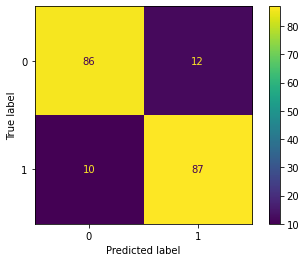

In [38]:
print(np.array([1,2]))
print(knn.classes_)
print(y_test)
print(y_pred)
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()
plt.show()

# {'metal': 0, 'classical': 1}

### Multiclass classification

To start, I will only use the top 5 classes and balance the dataset by using x samples from each class, where x is the number of samples in the smallest class. This will avoid having to deal with imbalanced data, but will also allow us to look at multi-class classification. The top 5 classes are:

* rock 13158
* metal 8782
* alternative 8778
* rap 5906
* dance 5624

In [21]:
top_5_genres = ['rock', 'metal', 'alternative', 'rap', 'dance']
print(top_5_genres)

['rock', 'metal', 'alternative', 'rap', 'dance']


In [22]:
lab_idx = {g:i for i,g in enumerate(top_5_genres)}
print(lab_idx)

{'rock': 0, 'metal': 1, 'alternative': 2, 'rap': 3, 'dance': 4}


In [23]:
min_recs = min([genre_cts[g] for g in top_5_genres]) 
min_recs

5624

Missed files:  0
Mean mfcc widths: 10256.8103, std: 4335.2332
Mean mfcc height: 20.0000, std: 0.0000
Width histogram for mfccs in top 5 genres


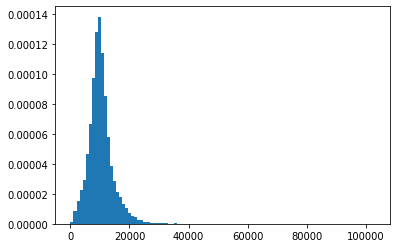

In [24]:
# get the mfcc lengths
l, h = get_mfcc_lengths(mfcc_path, top_5_genres, min_recs)

print('Mean mfcc widths: %.4f, std: %.4f' % (l.mean(), l.std())) #11098.8838, std: 4614.7522
print('Mean mfcc height: %.4f, std: %.4f' % (h.mean(), h.std())) #11098.8838, std: 4614.7522

print('Width histogram for mfccs in top 5 genres')
plt.hist(l, bins=100, density=True)
plt.show()

In [25]:
print('Max mfcc width: ', l.max())
print('Max mfcc height: ', h.max())

Max mfcc width:  103101
Max mfcc height:  20


In [26]:
# save l and h in a pickle
w_file = open('mfcc_widths_top_5_genres', 'ab')
pickle.dump(l, w_file)  
w_file.close()

h_file = open('mfcc_heights_top_5_genres', 'ab')
pickle.dump(h, h_file) 
h_file.close()

In [27]:
# should be this many samples
5624 * 5

28120

In [28]:
# ((28120, 20), (28120,))
x, y = get_mfccs(mfcc_path, top_5_genres, lab_idx, min_recs)
x.shape, y.shape

((28120, 20), (28120,))

In [29]:
# save x and y in a pickle

# x_file = open('mfcc_x_top_5_genres', 'ab')
# pickle.dump(x, x_file)  
# x_file.close()

# y_file = open('mfcc_y_top_5_genres', 'ab')
# pickle.dump(y, y_file) 
# y_file.close()

In [30]:
# open pickle
x_infile = open('mfcc_x_top_5_genres','rb')
x = pickle.load(x_infile)
x_infile.close()

y_infile = open('mfcc_y_top_5_genres','rb')
y = pickle.load(y_infile)
y_infile.close()

FileNotFoundError: [Errno 2] No such file or directory: 'mfcc_x_top_5_genres'

In [ ]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

In [ ]:
# choose best value of k
choose_k_value()

In [ ]:
# it still looks like 12 is the best value of k to use

knn= KNeighborsClassifier(n_neighbors=12)
knn.fit(x_train, y_train)
y_pred= knn.predict(x_test)
metrics.accuracy_score(y_test,y_pred) #.47

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=knn.classes_)
disp.plot()
plt.show()

# {'rock': 0, 'metal': 1, 'alternative': 2, 'rap': 3, 'dance': 4}
# Performance is best with predicting class 1 (metal) and class 3 (rap)

## KNN Model (from scratch)

Below is an implementation of the KNN model from scratch (without sklearn libraries). This is done for the purposes of comparing it to the sklearn model performance. 

In [ ]:
import statistics
from statistics import mode
from heapq import nlargest

In [ ]:
def calculate_distance(x_1, x_2):
    '''
    Calculate the distance between one sample and another sample
    '''
    return np.sqrt(np.sum(np.square(x_1-x_2)))

def calculate_nearest_neightbors(current_sample, k):
    '''
    Calculate distances between a sample and all other samples, to find the k closest samples.
    '''
    all_distances = {} # i is the compared training sample : distance to current test sample
    for i in range(len(x_train)):
        temp_distance = calculate_distance(current_sample, x_train[i])
        all_distances[i] = temp_distance
        
    nn_indices = nlargest(k, all_distances, key=all_distances.get)
            
    return nn_indices
        
def predict(k):
    
    # store predictions for each test sample here
    predictions = []
    
    # for each test sample...
    for i in range(len(x_test)):
        
        # get the train samples that it is nearest
        temp_nn_indicies = calculate_nearest_neightbors(x_test[i], k) # [ (idx_of_sample, [sample]), ... ]
        
        # use the index to look up the sample in the training data, and get the target value
        temp_preds = []
        for j in range(len(temp_nn_indicies)):
            current_index = temp_nn_indicies[j]
            temp_preds.append(y_train[current_index])
        
        # find the most frequent class that the sample was near in the training data (this is the prediction)
        predictions.append(mode(temp_preds))
        
    return predictions
    

In [ ]:
y_preds = predict(12)

In [ ]:
metrics.accuracy_score(y_test, y_preds) 

In [ ]:
print(classification_report(y_test, y_preds))

## Full Multi-class Classification

As a last step, I'll build a classifier for the full multi-class classification of all 32 mapped genres. In order to account for the imbalance in data, I'll use use an undersampling method from The imbalanced-learn developers's RandomUnderSampler which uses scikit-learn. 

Source: https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import seaborn as sns
sns.set()

In [ ]:
genres = list(genre_cts.keys())
print(genres)

In [ ]:
lab_idx = {g:i for i,g in enumerate(genres)}
print(lab_idx)

In [ ]:
# below is a version of the get_mfccs() function from earlier, but without the max_recs cut off, as we
# will be using a different method for dealing with the imbalnace in data. 

def get_mfccs_all(mfcc_path, genres, lab_idx):
    '''
    Open and process mfcc and return as x and y arrays.
    '''
    
    # save all x and y values
    mfccs = []
    y=[]
    i = 0
    
    # loop over each genre we are working with
    for genre in genres:
        print("genre: ", genre)
        
        # extract path to all song mfccs in current genre
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        # loop over each mfcc in current genre
        for fn in os.listdir(genre_path): 
            
            i += 1
            # get path to mfcc
            fp = '%s/%s' % (genre_path, fn)
            
            # load mfcc and transpose/take mean
            mfcc = np.load(fp) 
            mfcc = np.mean(mfcc.T,axis=0)
            if np.isnan(np.sum(mfcc)):
                print('Error with mfcc file')
                continue
            else:
                mfccs.append(mfcc)
            
            # append target label to list
            y.append(lab_idx[genre])
           
    # normalize data and create arrays
    x = np.array(mfccs)
    #x = normalize_data(x) # error with normalizing, will scale later
    y = np.array(y)
    
    return shuffle_data(x, y)

In [ ]:
x, y = get_mfccs_all(mfcc_path, genres, lab_idx)
x.shape, y.shape

In [ ]:
# check that all data is there
sum(genre_cts.values())

In [ ]:
# save x and y in a pickle

x_file_all = open('mfcc_x_all', 'ab')
pickle.dump(x, x_file_all)  
x_file_all.close()

y_file_all = open('mfcc_y_all', 'ab')
pickle.dump(y, y_file_all) 
y_file_all.close()

In [ ]:
# use principle component analysis to visualize the undersampling 
pca = PCA(n_components=2)
x_vis = pca.fit_transform(x)

In [ ]:
#random under-sampling
rus = RandomUnderSampler()
x_resampled, y_resampled = rus.fit_resample(x, y)
x_resampled_vis = pca.transform(x_resampled)

In [ ]:
# we now have a total of 736 samples
x_resampled.shape, y_resampled.shape

In [ ]:
# plot the x and x_resampled data (only plotting Acoustic, Alternative, Ambient, & Metal so it is easier to read plot)
# plotting code derived from code given in CS 6220 Data Mining course at NEU. 

almost_black = '#262626'
palette = sns.color_palette()

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,7))

ax1.scatter(x_vis[y == 0, 0], x_vis[y == 0, 1], label="Acoustic", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
ax1.scatter(x_vis[y == 1, 0], x_vis[y == 1, 1], label="Alternative", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[1], linewidth=0.15)
ax1.scatter(x_vis[y == 2, 0], x_vis[y == 2, 1], label="Ambient", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
ax1.scatter(x_vis[y == 19, 0], x_vis[y == 19, 1], label="Metal", alpha=0.5,
            edgecolor=almost_black, facecolor=palette[3], linewidth=0.15)


ax1.set_title('Original dataset')

ax2.scatter(x_resampled_vis[y_resampled == 0, 0], x_resampled_vis[y_resampled == 0, 1],
            label="Acoustic", alpha=.5, edgecolor=almost_black,
            facecolor=palette[0], linewidth=0.15)
ax2.scatter(x_resampled_vis[y_resampled == 1, 0], x_resampled_vis[y_resampled == 1, 1],
            label="Alternative", alpha=.5, edgecolor=almost_black,
            facecolor=palette[1], linewidth=0.15)
ax2.scatter(x_resampled_vis[y_resampled == 2, 0], x_resampled_vis[y_resampled == 2, 1],
            label="Ambient", alpha=.5, edgecolor=almost_black,
            facecolor=palette[2], linewidth=0.15)
ax2.scatter(x_resampled_vis[y_resampled == 19, 0], x_resampled_vis[y_resampled == 19, 1],
            label="Metal", alpha=.5, edgecolor=almost_black,
            facecolor=palette[3], linewidth=0.15)
ax2.set_title('Dataset with random undersampling')

plt.show()

In [ ]:
# split into train and test sets
# note we will use the data before PCA
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

In [ ]:
# scale data
sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
# choose best value of k
choose_k_value()

In [ ]:
# it looks like around 9 is the best value of k to use

knn= KNeighborsClassifier(n_neighbors=9)
knn.fit(x_train, y_train)
y_pred= knn.predict(x_test)
metrics.accuracy_score(y_test,y_pred) #.11

In [ ]:
print(classification_report(y_test, y_pred))

# f1 scores are not excellent, but with undersampling, there are not many samples
# and we see from the PCA visualizaton, that the mfcc features are rather overlapping already
# metal (19), which has the highest f1 score (.60), is more seperated on the PCA plot (in red)